In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# Note: Ignore the file walk as there are thousands of files.
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# CNN Cancer Detection

This notebook explores the Histopathologic Cancer Detection from Cukierski (2018) to identify metastatic tissue in histopathologic lymph node-section scans. It is a modified subset of PatchCamelyon (PCam) without duplicates (later, we do not need to check for duplicates). This project aims to output that the center 32x32px region of a patch contains at least one pixel of tumor tissue.

# Exploratory Data Analysis (EDA)

Firstly, let us understand the data we have been given. Let us explore the labels.

In [4]:
import pandas as pd

df = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


Let us check: What is the distribution of the labels (i.e., count)? Are there any null values (just checking)?

In [6]:
print(df['label'].value_counts())
print(df.isnull().sum())

label
0    130908
1     89117
Name: count, dtype: int64
id       0
label    0
dtype: int64


Let us visualize that distribution to see if there is any imbalance.

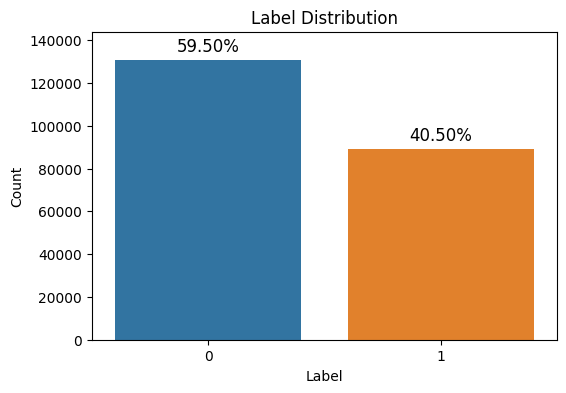

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

label_counts = df['label'].value_counts()
total = len(df)

# Plot
plt.figure(figsize=(6,4))
ax = sns.countplot(data=df, x='label')

for p in ax.patches:
    count = p.get_height()
    percent = f'{100 * count / total:.2f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.text(x, y + total * 0.01, percent, ha='center', va='bottom', fontsize=12)

# Format
plt.title("Label Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.ylim(0, label_counts.max() * 1.1)
plt.show()

This chart shows that 60% are non-cancerous and 40% are cancerous. There is a slight imbalance of data, but not too much. We'll continue as-is, but we may do some additional monitoring of the results (not just accuracy).

Moving on to the actual images, let us see how they look.

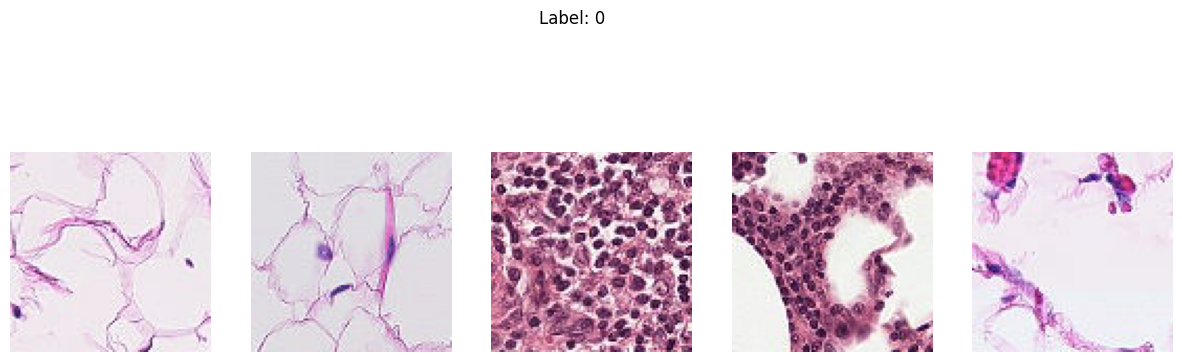

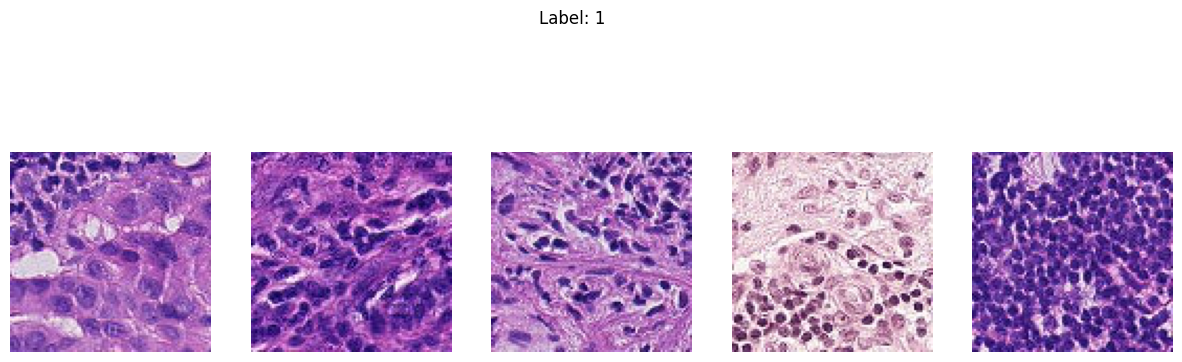

In [5]:
import cv2
import numpy as np
import os

def load_image(image_id, base_path='/kaggle/input/histopathologic-cancer-detection/train'):
    path = os.path.join(base_path, f"{image_id}.tif")
    return cv2.imread(path)

def show_samples(df, label, n=5):
    samples = df[df['label'] == label].sample(n)
    fig, axes = plt.subplots(1, n, figsize=(15, 5))
    for img_id, ax in zip(samples['id'], axes):
        img = load_image(img_id)
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.axis('off')
    plt.suptitle(f"Label: {label}")
    plt.show()

show_samples(df, label=0)
show_samples(df, label=1)

From this, the images are all the same size. We can get the actual size of an image by using 'shape'. This will tell us what is the width, height, and channels (RGB).

In [6]:
img = load_image(df['id'][0])
print("Image shape:", img.shape)

Image shape: (96, 96, 3)


So, it's a 96x96-pixel image with RGB (3 channels). Next, we want to check the distribution of pixels' colors in a sample image (also known as intensity). Can we see any pattern differences?

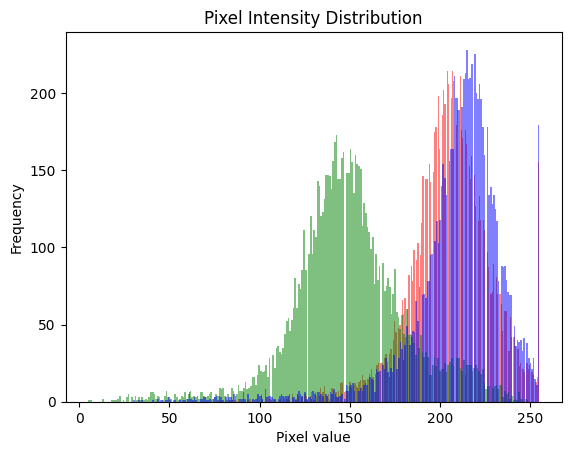

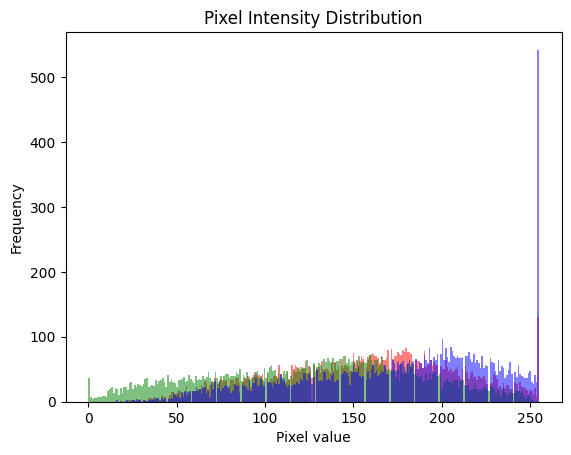

In [7]:
def plot_color_distribution_histogram(image):
    colors = ['r', 'g', 'b']
    for i, color in enumerate(colors):
        plt.hist(image[..., i].ravel(), bins=256, color=color, alpha=0.5)
    plt.title("Pixel Intensity Distribution")
    plt.xlabel("Pixel value")
    plt.ylabel("Frequency")
    plt.show()

img_tumor = load_image(df[df['label'] == 1].sample(1).iloc[0]['id'])
img_normal = load_image(df[df['label'] == 0].sample(1).iloc[0]['id'])

plot_color_distribution_histogram(img_tumor)
plot_color_distribution_histogram(img_normal)

From this, we can see that when cancer is present, there should be deeper colors—whereas when there is not, the colors are more spread and less concentrated. But this is only one sample, so we shouldn't extrapolate too much meaning right now. Since we know there are no duplicates or nulls, we do not need to clean the data.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


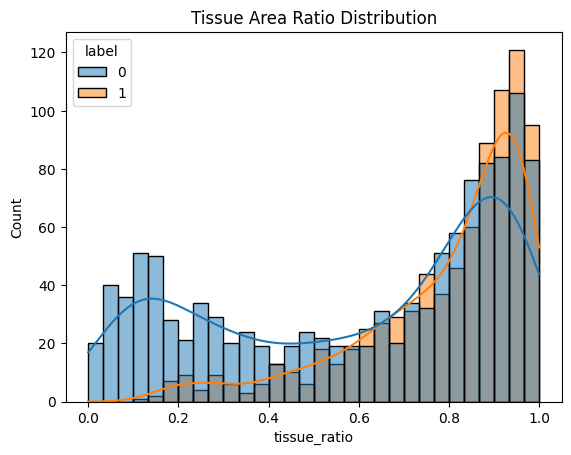

In [8]:
def tissue_ratio(img, threshold=200):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return np.mean(gray < threshold)

# Use only a sample for EDA
sample_ids = df['id'].sample(2000, random_state=42)

ratios = sample_ids.apply(lambda id_: tissue_ratio(load_image(id_)))
df['tissue_ratio'] = ratios

sns.histplot(data=df, x='tissue_ratio', hue='label', bins=30, kde=True)
plt.title("Tissue Area Ratio Distribution")
plt.show()

We have taken a sample of 2000 images here. Looking at the tissue area, we can see that the images with cancer are more distributed, with a higher ratio of tissue. In contrast, the images for non-cancerous tissue are spread more. This chart supports the previous finding from the pixel intensity graph.

**Set up for importing images**

To import the images, we need to add additional columns such as filename (which includes the ext) and convert the label to a string (required for ImageDataGenerator).

In [5]:
df['label_str'] = df['label'].astype(str)
df['filename'] = df['id'] + '.tif'

**Split the dataset**

The last thing we want to do is split the dataset so we can train the models. Here, we first take a sample of the dataset df_sampled and then use this sample to create a test/train split.

We only took a sample because if we loaded the whole dataset, Kaggle would crash. I've chosen 40K here, as this allows for faster iterations over the models.

In [6]:
from sklearn.model_selection import train_test_split

df_sampled, _ = train_test_split(
    df,
    train_size=40000,
    stratify=df['label'],
    random_state=42
)

train_df, val_df = train_test_split(
    df_sampled,
    test_size=0.2,                # 20% for validation
    stratify=df_sampled['label'],         # maintain class balance
    random_state=42               # reproducibility
)

print("Train label distribution:")
print(train_df['label'].value_counts(normalize=True))

print("\nValidation label distribution:")
print(val_df['label'].value_counts(normalize=True))

Train label distribution:
label
0    0.594969
1    0.405031
Name: proportion, dtype: float64

Validation label distribution:
label
0    0.595
1    0.405
Name: proportion, dtype: float64


Now, we will load all the images (data) and normalize them. Normalize means changing it from 0-255 to 0-1, so we divide by 255.

What is different here is that we load it all into a dataset. This means that if it's already cached and prefetched, it will make the GPU more efficient.

In [7]:
import cv2
import numpy as np
import tensorflow as tf

BATCH_SIZE = 32

def load_image_cv2(path):
    img = cv2.imread(path)
    img = cv2.resize(img, (96, 96))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img.astype(np.float32) / 255.0

def data_generator(paths, labels):
    for path, label in zip(paths, labels):
        img = load_image_cv2(path)
        yield img, label

train_paths = [f"/kaggle/input/histopathologic-cancer-detection/train/{f}" for f in train_df['filename']]
train_labels = train_df['label'].values.astype(np.float32)

val_paths = [f"/kaggle/input/histopathologic-cancer-detection/train/{f}" for f in val_df['filename']]
val_labels = val_df['label'].values.astype(np.float32)

train_data = tf.data.Dataset.from_generator(
    lambda: data_generator(train_paths, train_labels),
    output_signature=(
        tf.TensorSpec(shape=(96, 96, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.float32)
    )
).shuffle(1024).repeat().batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

val_data = tf.data.Dataset.from_generator(
    lambda: data_generator(val_paths, val_labels),
    output_signature=(
        tf.TensorSpec(shape=(96, 96, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.float32)
    )
).batch(BATCH_SIZE, drop_remainder=True).cache().prefetch(tf.data.AUTOTUNE)

The code below ensures we've loaded the dataset correctly. Previously, I had problems with data labelled as all zero or all one.

In [6]:
for images, labels in val_data.take(1):
    print(np.unique(labels.numpy(), return_counts=True))

(array([0., 1.], dtype=float32), array([21, 11]))


# Model Architecture

I will try two architectures with this CNN problem. The first is a basic model with a few layers and batch normalization. The second is the VGGNet that we learned about in class.

# Architecture 1: Basic Model with Batch Normalization

Here, we will create a model with only a few layers and normalization between each layer. This should be easy to train and shouldn't overfit too much with the batch normalization between the layers. This architecture is similar to the VGGNet architecture, but without as many layers.

In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

def build_basic(input_shape=(96, 96, 3)):
    model = models.Sequential(name="Basic_Model")
    model.add(layers.Input(shape=input_shape))

    model.add(layers.Conv2D(32, (3,3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())

    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.BatchNormalization())

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

basic_model = build_basic()
basic_model.summary()

Model: "Basic_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 96, 96, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 96, 96, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 96, 96, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 96, 96, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 147456)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │         147,457 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 167,489 (654.25 KB)

 Trainable params: 167,169 (653.00 KB)

 Non-trainable params: 320 (1.25 KB)

# Architecture 2: VGGNet

This follows the VGGNet architecture, which has multiple convolutional layers followed by a max-pool layer. This is then repeated N times (for simplicity, I've repeated it only 3 times). Inside the hidden layers, we will use relu and sigmoid to output the final result. We'll use dropout to help regulate the final output and ensure no overfitting.

In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_vgg_like(input_shape=(96, 96, 3)):
    model = models.Sequential(name="VGGNet")
    model.add(layers.Input(shape=input_shape))
    
    model.add(layers.Conv2D(32, (3,3), activation='relu', padding='same'))
    model.add(layers.Conv2D(32, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    
    model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    
    model.add(layers.Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(layers.Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model

vgg_model = build_vgg_like()
vgg_model.summary()

Model: "VGGNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 96, 96, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 96, 96, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 48, 48, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 48, 48, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       4,718,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,071,905 (19.35 MB)

 Trainable params: 5,071,905 (19.35 MB)

 Non-trainable params: 0 (0.00 B)

# Results and Analysis

Now, it's time to run our models and see if we can improve them. Firstly, I'll run the model for the basic architecture. We will then use the confusion matrix and the Area Under the Curve (AUC) to check for the model's accuracy. Since this is about medical data, I'll also want to know the false negative rate.

After this, we will run the second model (VGGNet) and perform the same evaluation. Finally, I'll perform some hyperparameter tuning on the best model, such as deciding what optimizer or loss to use.

All my models need to know how many steps per epoch to run. Knowing the number of steps prevents them from running out of data.

In [8]:
steps_per_epoch = len(train_df) // BATCH_SIZE

## Basic Model

In [22]:
import tensorflow as tf
from tensorflow.keras import layers, models

basic_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

callbacks_list = [
    # This helps stop the model early
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    ),
    # Reduces learning rate when plateued
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6,
        verbose=1
    ),
    # save best model
    callbacks.ModelCheckpoint(
        filepath='best_basic_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

bm_history = basic_model.fit(
    train_data, 
    validation_data = val_data, 
    epochs=10, 
    steps_per_epoch=steps_per_epoch,
    callbacks=callbacks_list
)
basic_model.evaluate(val_data)

Epoch 1/10
 999/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9238 - loss: 0.1960
Epoch 1: val_accuracy improved from -inf to 0.71075, saving model to best_basic_model.keras
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 57s 51ms/step - accuracy: 0.9238 - loss: 0.1960 - val_accuracy: 0.7107 - val_loss: 1.1139 - learning_rate: 0.0010
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9435 - loss: 0.1491
Epoch 2: val_accuracy improved from 0.71075 to 0.76587, saving model to best_basic_model.keras
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 49s 49ms/step - accuracy: 0.9435 - loss: 0.1491 - val_accuracy: 0.7659 - val_loss: 0.8378 - learning_rate: 0.0010
Epoch 3/10
 999/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9608 - loss: 0.1094
Epoch 3: val_accuracy improved from 0.76587 to 0.78137, saving model to best_basic_model.keras
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 49s 49ms/step - accuracy: 0.9608 - loss: 0.1094 - val_accuracy: 0.7814 - val_loss: 0.8892 - learning_rate: 0.0010
Epoch 4/10
 999/

[0.8377864360809326, 0.765874981880188]

Now that we have run our first model, let us plot the history for accuracy and loss.

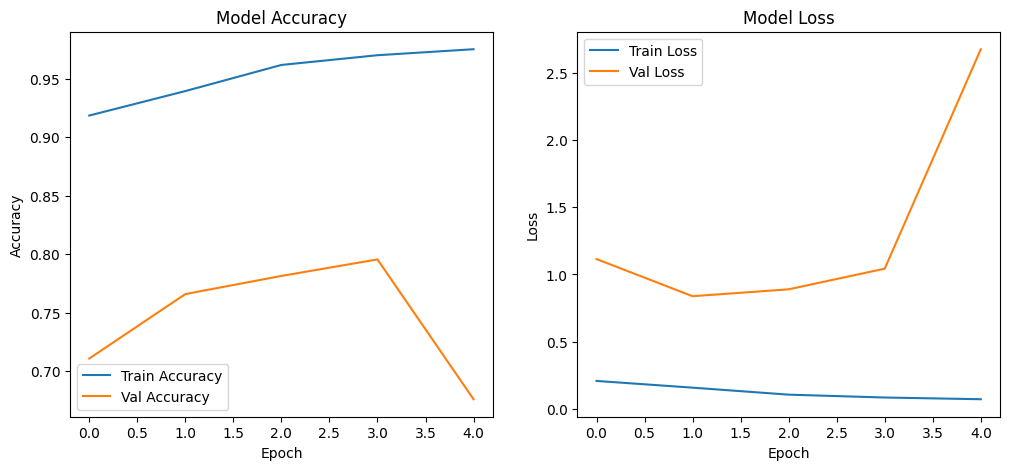

In [23]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(bm_history.history['accuracy'], label='Train Accuracy')
plt.plot(bm_history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(bm_history.history['loss'], label='Train Loss')
plt.plot(bm_history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

From this graph, we can see that the val accuracy initially increased but then decreased. The validation loss increases sharply when the accuracy decreases. The charts show that the model is likely overfitting and may not be good.

The next function helps get the predicted and true values for the labels. This is useful for creating the confusion matrix and AUC.

In [1]:
import numpy as np

def get_y_true_and_y_pred(val_data, model, threshold):

    # Predict on validation set
    y_true = []
    y_pred_probs = []
    
    for batch_x, batch_y in val_data:
        preds = model.predict(batch_x, verbose=0)
        y_pred_probs.extend(preds.ravel())  # Flatten to 1D list
        y_true.extend(batch_y.numpy().ravel())  # Convert from tensor to NumPy array
    
    # Convert to NumPy arrays
    y_true = np.array(y_true)
    y_pred_probs = np.array(y_pred_probs)
    
    # Convert probabilities to binary predictions
    y_pred = (y_pred_probs > threshold).astype(int)
    return y_true, y_pred

In [24]:
y_true_bm, y_pred_bm = get_y_true_and_y_pred(val_data, basic_model, 0.5)

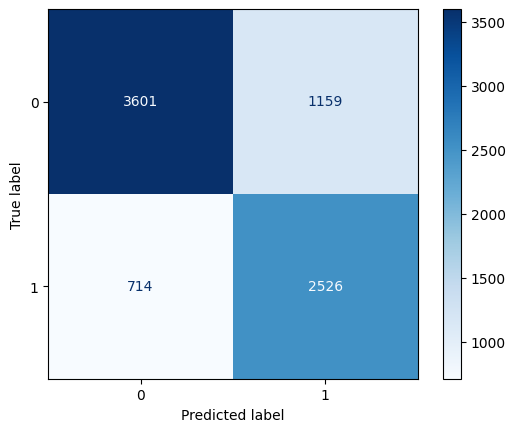

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion Matrix
cm = confusion_matrix(y_true_bm, y_pred_bm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

The confusion matrix shows that there are still many false negatives, which is not great for medical projects.

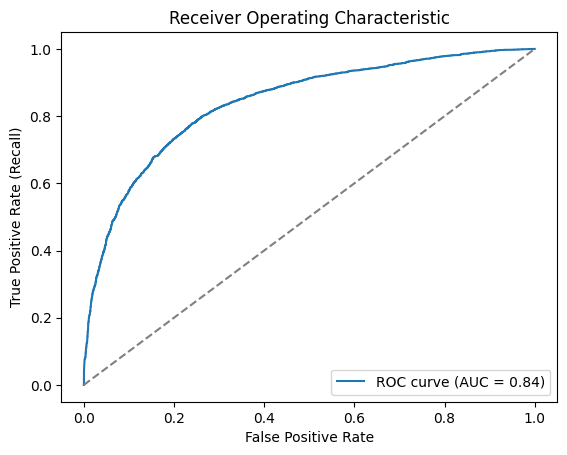

In [26]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_true_bm, y_pred_probs_bm)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


The ROC curve plot shows that the AUC is 0.84, which is not bad but also not great.

## VGGNet Model

In [14]:
train_data = tf.data.Dataset.from_generator(
    lambda: data_generator(train_paths, train_labels),
    output_signature=(
        tf.TensorSpec(shape=(96, 96, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.float32)
    )
).shuffle(1024).repeat().batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

val_data = tf.data.Dataset.from_generator(
    lambda: data_generator(val_paths, val_labels),
    output_signature=(
        tf.TensorSpec(shape=(96, 96, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.float32)
    )
).batch(BATCH_SIZE, drop_remainder=True).cache().prefetch(tf.data.AUTOTUNE)

In [15]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

vgg_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

callbacks_list = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6
    ),
    # save best model
    callbacks.ModelCheckpoint(
        filepath='best_vgg_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

vgg_history = vgg_model.fit(
    train_data, 
    validation_data = val_data, 
    epochs=10,
    steps_per_epoch=steps_per_epoch,
    callbacks=callbacks_list
)
vgg_model.evaluate(val_data)

Epoch 1/10


I0000 00:00:1747712021.365433      97 service.cc:148] XLA service 0x78fa54011a30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747712021.366287      97 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1747712021.821218      97 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/1000 ━━━━━━━━━━━━━━━━━━━━ 5:44:13 21s/step - accuracy: 0.5625 - loss: 0.6901

I0000 00:00:1747712025.732600      97 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.5996 - loss: 0.6481
Epoch 1: val_accuracy improved from -inf to 0.78312, saving model to best_vgg_model.keras


/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 486s 466ms/step - accuracy: 0.5997 - loss: 0.6481 - val_accuracy: 0.7831 - val_loss: 0.4698 - learning_rate: 0.0010
Epoch 2/10
 999/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.7886 - loss: 0.4657
Epoch 2: val_accuracy improved from 0.78312 to 0.81687, saving model to best_vgg_model.keras
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 53s 53ms/step - accuracy: 0.7886 - loss: 0.4657 - val_accuracy: 0.8169 - val_loss: 0.4242 - learning_rate: 0.0010
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8150 - loss: 0.4209
Epoch 3: val_accuracy improved from 0.81687 to 0.82963, saving model to best_vgg_model.keras
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 54s 54ms/step - accuracy: 0.8150 - loss: 0.4209 - val_accuracy: 0.8296 - val_loss: 0.3886 - learning_rate: 0.0010
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.8356 - loss: 0.3823
Epoch 4: val_accuracy did not improve from 0.82963
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 54s 54ms/step - accuracy: 0.

[0.3598569631576538, 0.8508750200271606]

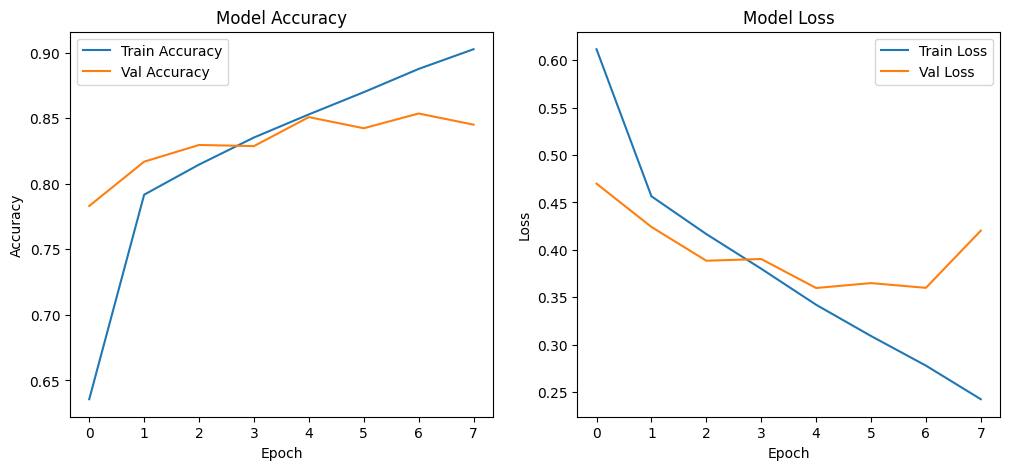

In [16]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(vgg_history.history['accuracy'], label='Train Accuracy')
plt.plot(vgg_history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(vgg_history.history['loss'], label='Train Loss')
plt.plot(vgg_history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

We notice that the training loss decreases, but the validation loss increases. This suggests overfitting on the training data. Also, the value loss is not going anywhere, which could suggest that the learning rate is too high and overshot.

In [17]:
y_true_vgg, y_pred_vgg = get_y_true_and_y_pred(val_data, vgg_model, 0.5)

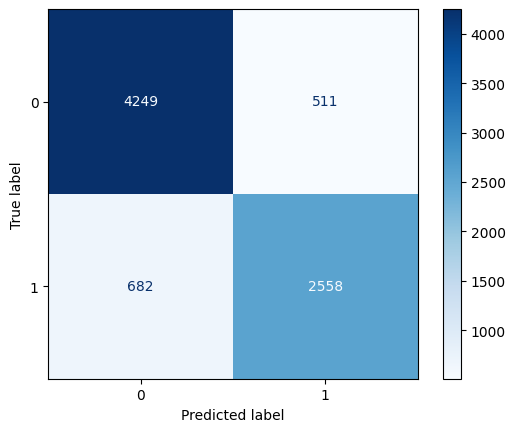

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion Matrix
cm = confusion_matrix(y_true_vgg, y_pred_vgg)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

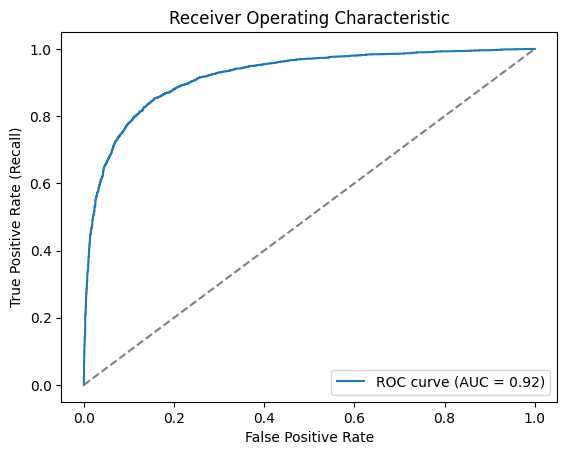

In [19]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_true_vgg, y_pred_probs_vgg)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

Now, let us tune the model's hyperparameters. It's already very good, but considering this is medical data, we want to avoid false negatives and minimize them.

Firstly, we want to tune the learning rate. The default is 1e-3, so we will take it down to 1e-4.

## Tuning: VGGNet Model - Learning Rate

This block of code resets the iterators.

In [25]:
train_data = tf.data.Dataset.from_generator(
    lambda: data_generator(train_paths, train_labels),
    output_signature=(
        tf.TensorSpec(shape=(96, 96, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.float32)
    )
).shuffle(1024).repeat().batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

val_data = tf.data.Dataset.from_generator(
    lambda: data_generator(val_paths, val_labels),
    output_signature=(
        tf.TensorSpec(shape=(96, 96, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.float32)
    )
).batch(32, drop_remainder=True).cache().prefetch(tf.data.AUTOTUNE)

In [26]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

new_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

vgg_model.compile(optimizer=new_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

callbacks_list = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6
    ),
    # save best model
    callbacks.ModelCheckpoint(
        filepath='best_vgg_model_v1.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

vgg_history_v2 = vgg_model.fit(
    train_data, 
    validation_data = val_data, 
    epochs=10,
    steps_per_epoch=steps_per_epoch,
    callbacks=callbacks_list
)
vgg_model.evaluate(val_data)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.8870 - loss: 0.2721
Epoch 1: val_accuracy improved from -inf to 0.86638, saving model to best_vgg_model_v1.keras
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 111s 103ms/step - accuracy: 0.8870 - loss: 0.2720 - val_accuracy: 0.8664 - val_loss: 0.3307 - learning_rate: 1.0000e-04
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8925 - loss: 0.2598
Epoch 2: val_accuracy did not improve from 0.86638
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 52s 52ms/step - accuracy: 0.8925 - loss: 0.2598 - val_accuracy: 0.8641 - val_loss: 0.3346 - learning_rate: 1.0000e-04
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8992 - loss: 0.2499
Epoch 3: val_accuracy did not improve from 0.86638
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 53s 53ms/step - accuracy: 0.8993 - loss: 0.2499 - val_accuracy: 0.8493 - val_loss: 0.3702 - learning_rate: 1.0000e-04
Epoch 4/10
 999/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9057 - loss: 0.2370


[0.3307090401649475, 0.8663750290870667]

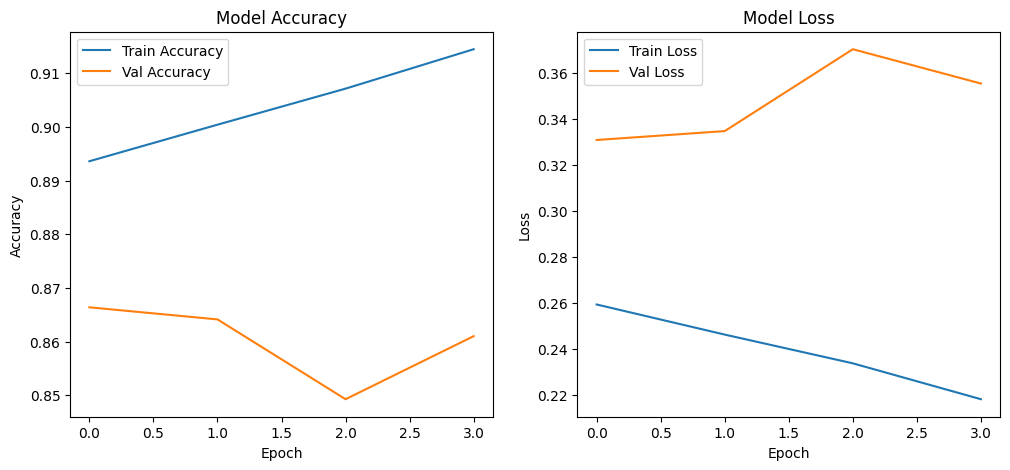

In [27]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(vgg_history_v2.history['accuracy'], label='Train Accuracy')
plt.plot(vgg_history_v2.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(vgg_history_v2.history['loss'], label='Train Loss')
plt.plot(vgg_history_v2.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

We can see that the validation loss is still increasing while the train loss is still decreasing. The loss in different directions suggests potential overfitting, so we will adapt the model to add a dropout layer.

## VGGNet Model Tuning: Additional Dropout Layer

In [23]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_vgg_like_v2(input_shape=(96, 96, 3)):
    model = models.Sequential(name="VGGNetv2")
    model.add(layers.Input(shape=input_shape))
    
    model.add(layers.Conv2D(32, (3,3), activation='relu', padding='same'))
    model.add(layers.Conv2D(32, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    
    model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    
    model.add(layers.Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(layers.Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model

vgg_model_v2 = build_vgg_like_v2()
vgg_model_v2.summary()

Model: "VGGNetv2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 96, 96, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 96, 96, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 48, 48, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 48, 48, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │       4,718,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,071,905 (19.35 MB)

 Trainable params: 5,071,905 (19.35 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
train_data = tf.data.Dataset.from_generator(
    lambda: data_generator(train_paths, train_labels),
    output_signature=(
        tf.TensorSpec(shape=(96, 96, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.float32)
    )
).shuffle(1024).repeat().batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

val_data = tf.data.Dataset.from_generator(
    lambda: data_generator(val_paths, val_labels),
    output_signature=(
        tf.TensorSpec(shape=(96, 96, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.float32)
    )
).batch(BATCH_SIZE, drop_remainder=True).cache().prefetch(tf.data.AUTOTUNE)

In [46]:
new_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

vgg_model_v2.compile(optimizer=new_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

callbacks_list = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6
    ),
    # save best model
    callbacks.ModelCheckpoint(
        filepath='best_vgg_model_v2.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

vgg_history_v3 = vgg_model_v2.fit(
    train_data, 
    validation_data = val_data, 
    epochs=10,
    steps_per_epoch=steps_per_epoch,
    callbacks=callbacks_list
)
vgg_model_v2.evaluate(val_data)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.7139 - loss: 0.5483
Epoch 1: val_accuracy improved from -inf to 0.79150, saving model to best_vgg_model_v2.keras
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 82s 75ms/step - accuracy: 0.7139 - loss: 0.5482 - val_accuracy: 0.7915 - val_loss: 0.4538 - learning_rate: 1.0000e-04
Epoch 2/10
 999/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8009 - loss: 0.4453
Epoch 2: val_accuracy improved from 0.79150 to 0.82363, saving model to best_vgg_model_v2.keras
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 48s 48ms/step - accuracy: 0.8009 - loss: 0.4453 - val_accuracy: 0.8236 - val_loss: 0.4031 - learning_rate: 1.0000e-04
Epoch 3/10
 999/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8173 - loss: 0.4123
Epoch 3: val_accuracy improved from 0.82363 to 0.84588, saving model to best_vgg_model_v2.keras
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 48s 48ms/step - accuracy: 0.8173 - loss: 0.4123 - val_accuracy: 0.8459 - val_loss: 0.3642 - learning_rate: 1.0000e-04
E

[0.2832103967666626, 0.8840000033378601]

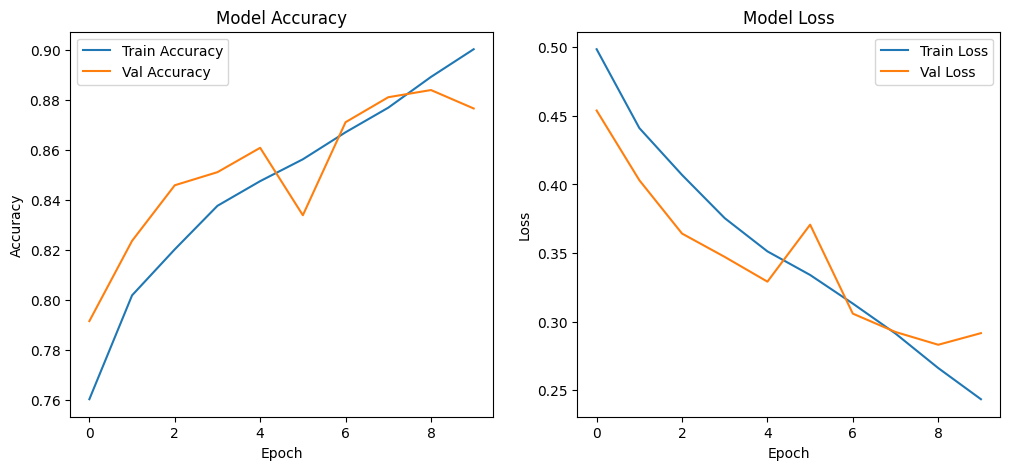

In [47]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(vgg_history_v3.history['accuracy'], label='Train Accuracy')
plt.plot(vgg_history_v3.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(vgg_history_v3.history['loss'], label='Train Loss')
plt.plot(vgg_history_v3.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

Finally, we are on the right track. The accuracy for both val and train is heading upwards, and the model loss is heading downwards. For the final tuning, we want to add some L2 regularization to the final dense layers.

## VGGNet Model Tuning: L2 Regularization

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_vgg_like_v3(input_shape=(96, 96, 3)):
    model = models.Sequential(name="VGGNetv3")
    model.add(layers.Input(shape=input_shape))
    
    model.add(layers.Conv2D(32, (3,3), activation='relu', padding='same'))
    model.add(layers.Conv2D(32, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    
    model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    
    model.add(layers.Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(layers.Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model

vgg_model_v3 = build_vgg_like_v3()
vgg_model_v3.summary()

Model: "VGGNetv3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 96, 96, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 96, 96, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 48, 48, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 48, 48, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       4,718,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,071,905 (19.35 MB)

 Trainable params: 5,071,905 (19.35 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
train_data = tf.data.Dataset.from_generator(
    lambda: data_generator(train_paths, train_labels),
    output_signature=(
        tf.TensorSpec(shape=(96, 96, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.float32)
    )
).shuffle(1024).repeat().batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

val_data = tf.data.Dataset.from_generator(
    lambda: data_generator(val_paths, val_labels),
    output_signature=(
        tf.TensorSpec(shape=(96, 96, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.float32)
    )
).batch(BATCH_SIZE, drop_remainder=True).cache().prefetch(tf.data.AUTOTUNE)

In [29]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

new_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

vgg_model_v3.compile(optimizer=new_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

callbacks_list = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6
    ),
    # save best model
    callbacks.ModelCheckpoint(
        filepath='best_vgg_model_v3.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

vgg_history_v4 = vgg_model_v3.fit(
    train_data, 
    validation_data = val_data, 
    epochs=10,
    steps_per_epoch=steps_per_epoch,
    callbacks=callbacks_list
)
vgg_model_v3.evaluate(val_data)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9018 - loss: 0.2567
Epoch 1: val_accuracy improved from -inf to 0.90812, saving model to best_vgg_model_v3.keras
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 72s 65ms/step - accuracy: 0.9018 - loss: 0.2567 - val_accuracy: 0.9081 - val_loss: 0.2481 - learning_rate: 1.0000e-04
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9046 - loss: 0.2518
Epoch 2: val_accuracy did not improve from 0.90812
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 52s 52ms/step - accuracy: 0.9046 - loss: 0.2518 - val_accuracy: 0.8931 - val_loss: 0.2936 - learning_rate: 1.0000e-04
Epoch 3/10
 999/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9140 - loss: 0.2381
Epoch 3: val_accuracy did not improve from 0.90812
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 50s 50ms/step - accuracy: 0.9140 - loss: 0.2381 - val_accuracy: 0.8994 - val_loss: 0.2642 - learning_rate: 1.0000e-04
Epoch 4/10
 999/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9143 - loss: 0.2326
Ep

[0.21697117388248444, 0.9233750104904175]

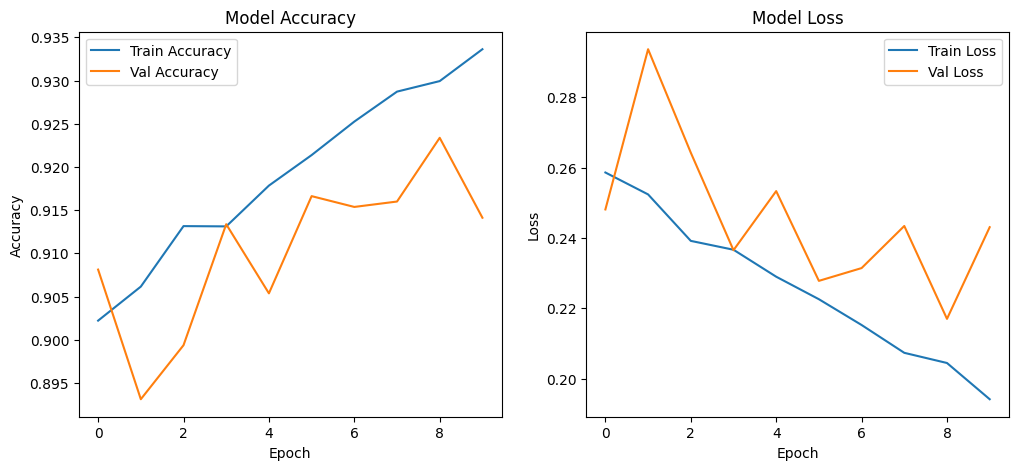

In [30]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(vgg_history_v4.history['accuracy'], label='Train Accuracy')
plt.plot(vgg_history_v4.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(vgg_history_v4.history['loss'], label='Train Loss')
plt.plot(vgg_history_v4.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

Here, we can see again that the val accuracy goes up as the train accuracy goes up, and the same is true for the loss. Both lines going in the same direction show that our final tuning worked neatly. We see many spikes, which show that it is pretty noisy and bounces around.

In [31]:
y_true_vgg, y_pred_vgg = get_y_true_and_y_pred(val_data, vgg_model, 0.5)

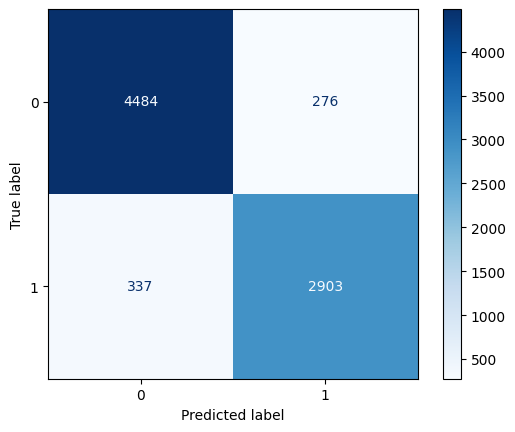

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion Matrix
cm = confusion_matrix(y_true_vgg, y_pred_vgg)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

We have reduced the false negatives, but there are still some, which means this would not necessarily be good for medical purposes.

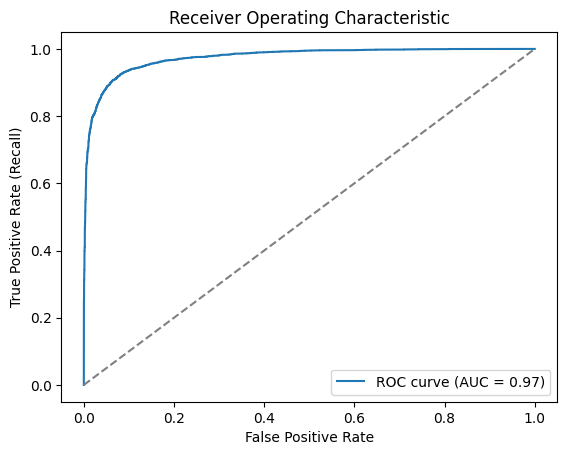

In [33]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_true_vgg, y_pred_probs_vgg)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

The Area under the curve is 0.97, which is really great! So, our model has improved by tuning from AUC 0.92 to AUC 0.97.
Now, I want to look at the false negative rate for the final results, which is 1-Recall (true positive rate).

The code below (commented out) is used to submit to the Kaggle competition. I scored 0.7809.

In [6]:
#import os
#import pandas as pd

# Get all .tif filenames from the test folder
#test_dir = "/kaggle/input/histopathologic-cancer-detection/test/"
#test_filenames = sorted([f for f in os.listdir(test_dir) if f.endswith(".tif")])

# Extract IDs by removing ".tif"
#test_ids = [f[:-4] for f in test_filenames]

In [7]:
#import tensorflow as tf
#import cv2
#import numpy as np

#def test_data_generator(paths):
#    for path in paths:
#        img = load_image_cv2(path)
#        yield img

# Create full paths
#test_paths = [os.path.join(test_dir, fname) for fname in test_filenames]

# Create tf.data.Dataset
#test_dataset = tf.data.Dataset.from_generator(
#    lambda: test_data_generator(test_paths),
#    output_signature=tf.TensorSpec(shape=(96, 96, 3), dtype=tf.float32)
#).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
#from tensorflow.keras.models import load_model

#best_model = load_model('best_vgg_model_v3.keras')

#pred_probs = best_model.predict(test_dataset, verbose=1)
#pred_labels = (pred_probs > 0.5).astype(int).flatten()

I0000 00:00:1747639934.351115      83 service.cc:148] XLA service 0x7879c8024fb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747639934.351954      83 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1747639934.481430      83 cuda_dnn.cc:529] Loaded cuDNN version 90300


      1/Unknown 2s 2s/step

I0000 00:00:1747639935.961530      83 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


    168/Unknown 36s 205ms/step

In [ ]:
#submission_df = pd.DataFrame({
#    'id': test_ids,
#    'label': pred_labels
#})

#submission_df.to_csv("submission.csv", index=False)

# Conclusion

Let us load the models and calculate the accuracy and recall scores.

In [8]:
from sklearn.metrics import recall_score, accuracy_score
from tensorflow.keras.models import load_model

basic_model = load_model('best_basic_model.keras')
y_true_bm, y_pred_bm = get_y_true_and_y_pred(val_data, basic_model, 0.5)

bm_rc = recall_score(y_true_bm, y_pred_bm)
bm_ac = accuracy_score(y_true_bm, y_pred_bm)

I0000 00:00:1747718841.262888      98 service.cc:148] XLA service 0x7819ec065210 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747718841.263845      98 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1747718841.369995      98 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1747718842.566826      98 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [9]:
from sklearn.metrics import recall_score, accuracy_score
from tensorflow.keras.models import load_model

vgg_model = load_model('best_vgg_model.keras')
y_true_vgg, y_pred_vgg = get_y_true_and_y_pred(val_data, vgg_model, 0.5)

vgg_rc = recall_score(y_true_vgg, y_pred_vgg)
vgg_ac = accuracy_score(y_true_vgg, y_pred_vgg)

In [10]:
from sklearn.metrics import recall_score, accuracy_score
from tensorflow.keras.models import load_model

vgg_model_lr = load_model('best_vgg_model_v1.keras')
y_true_vgg_lr, y_pred_vgg_lr = get_y_true_and_y_pred(val_data, vgg_model_lr, 0.5)

vgg_lr_rc = recall_score(y_true_vgg_lr, y_pred_vgg_lr)
vgg_lr_ac = accuracy_score(y_true_vgg_lr, y_pred_vgg_lr)

In [11]:
from sklearn.metrics import recall_score, accuracy_score
from tensorflow.keras.models import load_model

vgg_model_v2 = load_model('best_vgg_model_v2.keras')
y_true_vgg_v2, y_pred_vgg_v2 = get_y_true_and_y_pred(val_data, vgg_model_v2, 0.5)

vgg_v2_rc = recall_score(y_true_vgg_v2, y_pred_vgg_v2)
vgg_v2_ac = accuracy_score(y_true_vgg_v2, y_pred_vgg_v2)

In [12]:
from sklearn.metrics import recall_score, accuracy_score
from tensorflow.keras.models import load_model

vgg_model_v3 = load_model('best_vgg_model_v3.keras')
y_true_vgg_v3, y_pred_vgg_v3 = get_y_true_and_y_pred(val_data, vgg_model_v3, 0.5)

vgg_v3_rc = recall_score(y_true_vgg_v3, y_pred_vgg_v3)
vgg_v3_ac = accuracy_score(y_true_vgg_v3, y_pred_vgg_v3)

We want to focus on the miss rate. As this is medical data, we don't want to (false) negatively identify patients.

In [14]:
results = {
    'Model': ['Basic Model', 'VGG Model', 'VGG Model with 1e-4 LR', 'VGG Model v2', 'VGG Model v3'],
    'Accuracy': [bm_ac, vgg_ac, vgg_lr_ac, vgg_v2_ac, vgg_v3_ac],
    'Recall': [bm_rc, vgg_rc, vgg_lr_rc, vgg_v2_rc, vgg_v3_rc],
    'Miss Rate': [1 - bm_rc, 1 - vgg_rc, 1 - vgg_lr_rc, 1 - vgg_v2_rc, 1 - vgg_v3_rc]
}

df_result = pd.DataFrame(results).sort_values(by=['Miss Rate'], ascending=True)
df_result

,Model,Accuracy,Recall,Miss Rate
4,VGG Model v3,0.923375,0.895988,0.104012
3,VGG Model v2,0.884000,0.837346,0.162654
2,VGG Model with 1e-4 LR,0.866375,0.810802,0.189198
1,VGG Model,0.853625,0.791975,0.208025
0,Basic Model,0.795500,0.771605,0.228395


From the table of results above, we can clearly see that the VGGNet Model V3 (smaller learning rate, additional dropout layer, and L2 regularization) has really improved the model. The accuracy improved from 0.796 to 0.923. The recall (true positive rate) also improved from 0.772 to 0.896. Finally, the miss rate (or false negative rate) was 0.104. This means we will miss 1 out of every 10. Now, that does not sound great from a medical perspective.

## Learning and Improvements

We saw that the model performed better each time we tuned it. This shows that there was a lot of overfitting on the training data, and we needed the additional regularization and dropout. But there is still more we can improve. We did not try different optimizers. We also needed to reduce the data size to make it runnable in Kaggle. 

* Increase dataset sample size.
* Try different optimizers.
* Add additional VGGNet layers.
* Try different model types. We noticed early stopping. We may need to use Google's InceptionNet.
* Longer epochs

## Conclusion

While this model received a reasonable score of 0.7809 from the actual Kaggle test data, from a medical perspective, I would not trust it. We can still make many improvements as we tune the models more going forward. Overall, it is a good start, but we still have a lot of work to do.

# References

Aitken, A. M. (2025). Titanic - ML from Disaster (Supervised Learning), 8. Retrieved 05/13/2025 from https://www.kaggle.com/code/alexandermaitken/titanic-ml-from-disaster-supervised-learning#Titanic---ML-from-Disaster

Cukierski, W. (2018). Histopathologic Cancer Detection, 1. Retrieved 04/10/2025 from https://www.kaggle.com/competitions/histopathologic-cancer-detection.

You can find a copy of the notebook in my Github: https://github.com/alexmaitken/csca5642-week3